# ◆Car Fuel Consumption
### 目的：100kmあたりのガソリン消費量を予測する
#### 目的変数をconsumeとする回帰問題として、Lasso回帰モデルを作成する
- kaggle URL:https://www.kaggle.com/anderas/car-consume
- Create Date：2019/01/06／Author：M.Hasegawa
#### ───────────────────────────────────────────────────────────────────────────────────

### 【手順】

### 0.Notebook内で利用する関数の定義

### 1.データ読込
- 欠損項目を確認する

### 2.データ前処理
- 事前に予測できない項目は、除外する。
- 目的変数を説明するのに有効そうな説明変数を見つける。
- 目的変数と説明変数の関係を確認するためのグラフを作成する。
- 質的変数が扱えない場合は、ダミー変数に置き換える。

### 3.モデル生成
- Lasso回帰モデルを利用する

### 4.モデル評価
- MSE,RMSE,MAEを求める

### ※データセット
・利用するデータ「measurements.csv」（データ数：388行12列）

| 列 | 項目 | 項目名 | 欠損有無 | 利用有無 |
| :--- | :--- | :--- | :---: | :---: |
|  1 | distance | 走行していたキロメートル単位の距離 | - | ○ |
|  2 | consume | ディスプレイに表示される100キロメートルあたりのリットル単位の消費 | - | ○ |
|  3 | speed | 平均速度 | - | ○ |
|  4 | temp_inside | 加熱の設定 | 欠損あり | ○ |
|  5 | temp_outside | 外気温度 | - | ○ |
|  6 | specials | 雨または雪、気候変動が発生している場合（「AC」） | 欠損あり | × |
|  7 | gas_type | ガソリンの種類 | - | ○ |
|  8 | AC | ホットエンコードされた特別な「AC」 | - | ○ |
|  9 | rain | 雨/雪 | - | ○ |
| 10 | sun | 晴れ | - | ○ |
| 11 | refill liters | リフィルリッター | 欠損あり | × |
| 12 | refill gas| リフィルガス | 欠損あり | × |

## 0.Notebook内で利用する関数の定義

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.linear_model import (LinearRegression,Ridge,Lasso)
# 警告非表示
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 関数：gas_type別のヒストグラムと歪度
# 引数：データ名,グラフの横幅、縦幅、刻み数（棒の数）
# ============================================================================
def show_histogram(col_name,w,h,bins_val):
    print('\n▼ ' + str(col_name) + 'の分布 ※歪度：',df[col_name].skew())
    plt.figure(figsize=(w,h))
    sns.distplot(df[df['gas_type']=="E10"][col_name],kde=False,rug=False,bins=bins_val,label='E10')
    sns.distplot(df[df['gas_type']=="SP98"][col_name],kde=False,rug=False,bins=bins_val,label='SP98')
    plt.title('Histogram of ' + str(col_name) + ' (bins = ' + str(bins_val) + ')')
    plt.legend()
    plt.show()

# ============================================================================
# 関数：対数変換した成功と失敗別のヒストグラム
# 引数：データ名,グラフの横幅、縦幅、刻み数（棒の数）
# ============================================================================
def show_histogram_log1p(col_name,w,h,bins_val):
    print('\n▼ 対数変換した' + str(col_name) + 'の分布')
    plt.figure(figsize=(w,h))
    sns.distplot(np.log1p(df[df['gas_type']=="E10"][col_name]),kde=False,rug=False,bins=bins_val,label='E10')
    sns.distplot(np.log1p(df[df['gas_type']=="SP98"][col_name]),kde=False,rug=False,bins=bins_val,label='SP98')
    plt.title('Histogram of ' + str(col_name) + ' (bins = ' + str(bins_val) + ')')
    plt.xlabel(col_name)
    plt.legend()
    plt.show()
    
# ============================================================================
# 関数：gas_type別に散布図を表示するグラフ
# 引数：データ名,グラフの横幅、縦幅
# ============================================================================
def show_scatter_plot(col_name, w, h):
    print('\n▼ ' + str(col_name) + 'の散布図')
    plt.figure(figsize=(w,h))
    data1 = df.query('gas_type == "E10"') # E10
    data2 = df.query('gas_type == "SP98"') # SP98
    plt.grid(which='major',color='black',linestyle=':')
    plt.grid(which='minor',color='black',linestyle=':')
    plt.plot(data1.index, data1[col_name], 'o', color='C0', label='E10')
    plt.plot(data2.index, data2[col_name], 'o', color='C1', label='SP98')
    plt.legend(loc='best')
    plt.ylabel(col_name)
    plt.xlabel('row_index')
    plt.title('Scatter plot of ' + str(col_name))
    plt.show()
    
# ============================================================================
# 関数：2項目を散布図を表示するグラフ
# 引数：データ名,グラフの横幅、縦幅
# ============================================================================
def show_scatter_plot_2item(col_name1,col_name2, w, h):
    print('\n▼ ' + str(col_name1) + 'と' + str(col_name2) + 'の散布図')
    plt.figure(figsize=(w,h))
    data1 = df.query('gas_type == "E10"') # E10
    data2 = df.query('gas_type == "SP98"') # SP98
    plt.grid(which='major',color='black',linestyle=':')
    plt.grid(which='minor',color='black',linestyle=':')
    plt.plot(data1[col_name2], data1[col_name1], 'o', color='C0', label='E10')
    plt.plot(data2[col_name2], data2[col_name1], 'o', color='C1', label='SP98')
    plt.legend(loc='best')
    plt.ylabel(col_name1)
    plt.xlabel(col_name2)
    plt.title('Scatter plot of ' + str(col_name1) + ' and ' + str(col_name2))
    plt.show()

## 1.データ読込

In [2]:
# ****************************************************************************
# ◆ 1.データ読込
# ****************************************************************************
df = pd.read_excel("./measurements2.xlsx")

print("\n▼ 先頭5行表示")
display(df.head(5))

print("\n▼ 基本統計量")
display(df.describe())

print('\n▼ 欠損データ確認')
display(pd.DataFrame(df.isnull().sum()[df.isnull().sum()>0],columns=['Missing num']))

# 欠損項目および不要項目を削除
df = df.drop(['specials','refill liters','refill gas'], axis=1)

# 欠損値の補完
df['temp_inside'] = df['temp_inside'].fillna(df['temp_inside'].median()) # 中央値

# 欠損項目および不要項目を削除
#df = df.drop(['temp_inside','temp_outside'], axis=1)

print("\n▼ 先頭5行表示")
display(df.head(5))



▼ 先頭5行表示


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN



▼ 基本統計量


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000,13.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,37.115385
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441,8.587282
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,10.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,37.600000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,38.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,39.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000



▼ 欠損データ確認


,Missing num
temp_inside,12
specials,295
refill liters,375
refill gas,375



▼ 先頭5行表示


,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
0,28.0,5.0,26,21.5,12,E10,0,0,0
1,12.0,4.2,30,21.5,13,E10,0,0,0
2,11.2,5.5,38,21.5,15,E10,0,0,0
3,12.9,3.9,36,21.5,14,E10,0,0,0
4,18.5,4.5,46,21.5,15,E10,0,0,0


## 2.データ前処理

<Figure size 720x432 with 0 Axes>

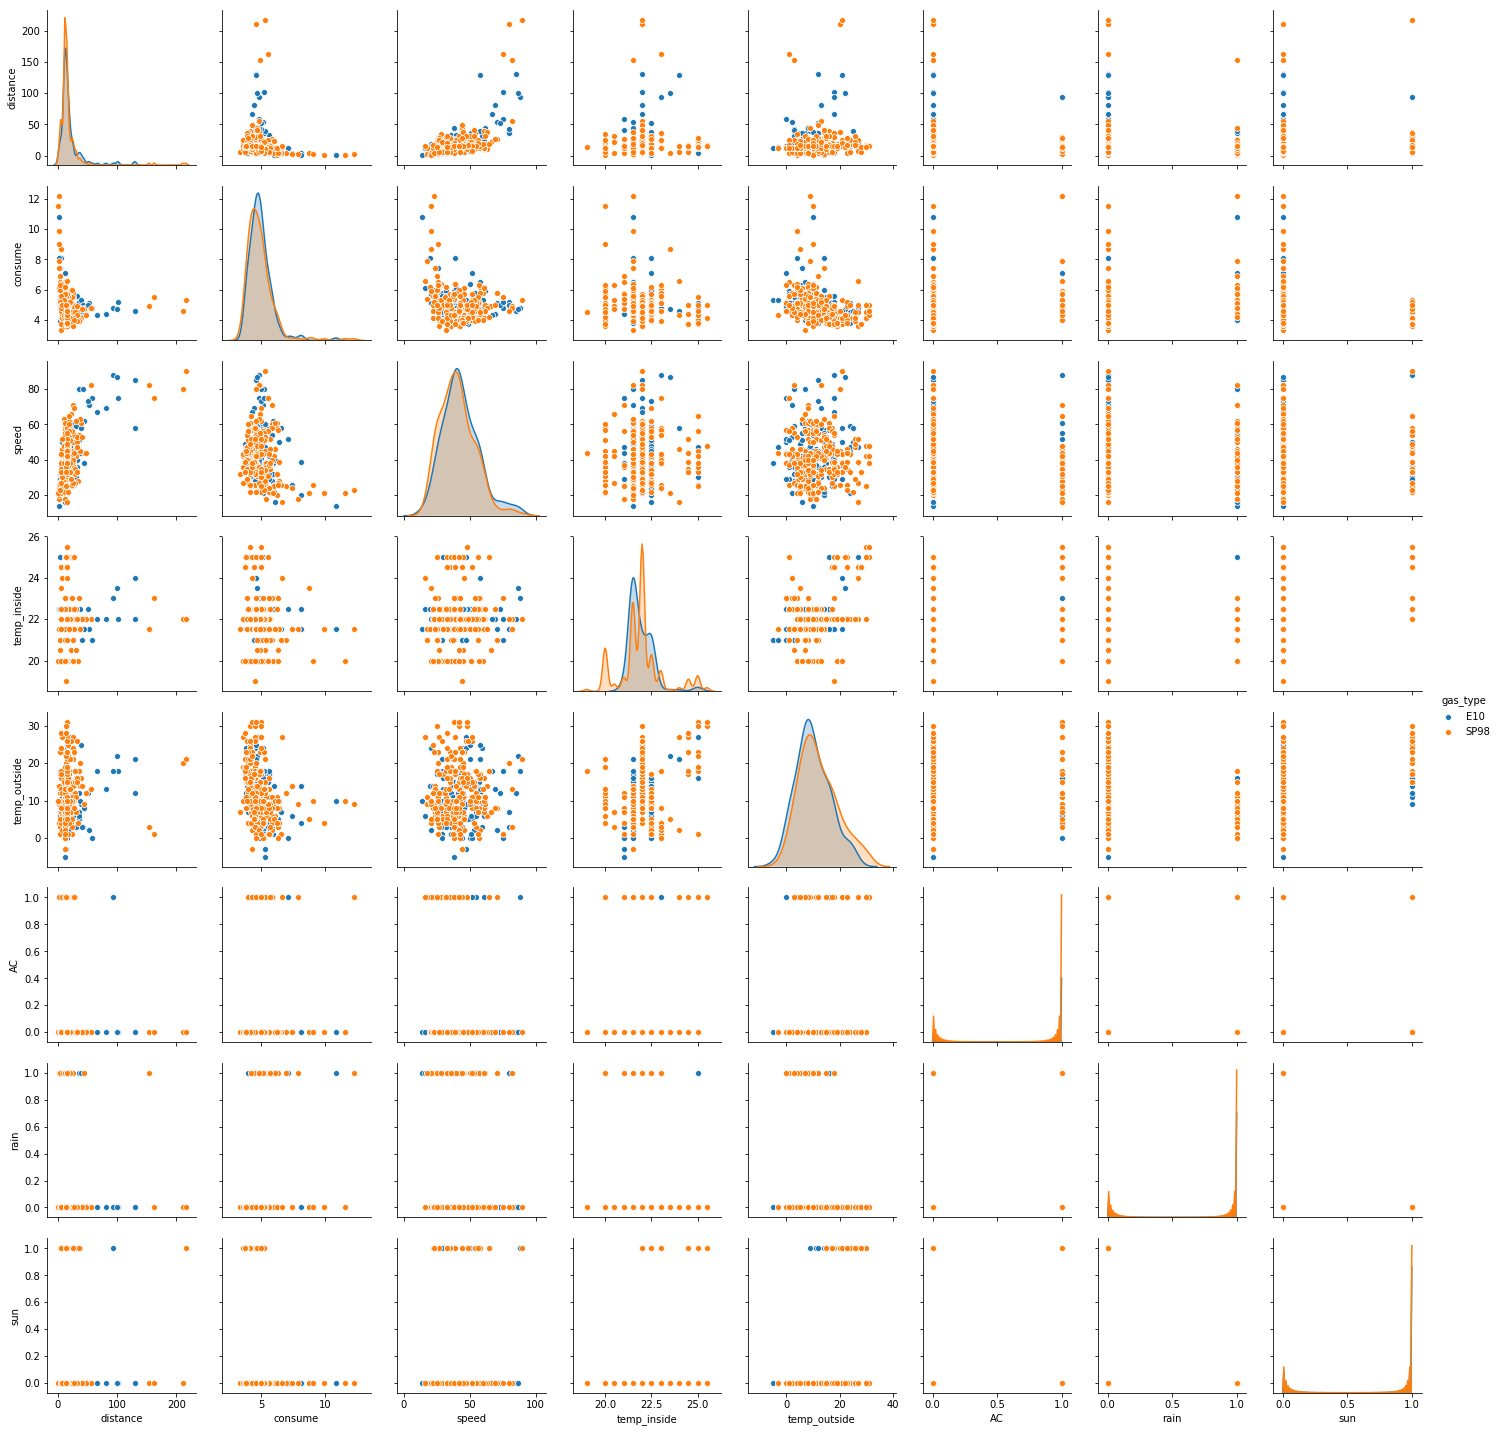


▼ 説明変数（数値項目）同士の相関係数をヒートマップにして可視化


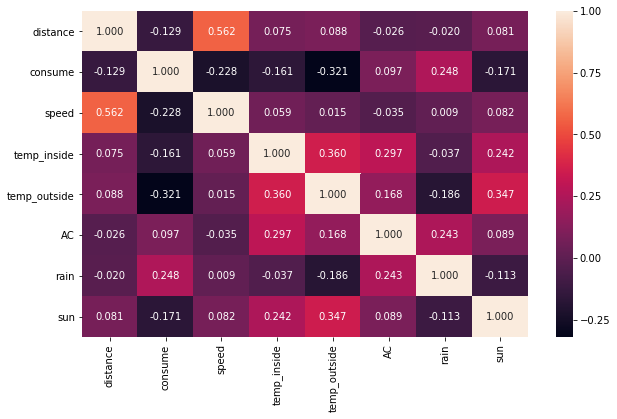

In [3]:
# ****************************************************************************
# ◆ 2.前処理
# ****************************************************************************
# ------------------------------------------------
# 2-1.説明変数の選定
# ------------------------------------------------

# 散布図行列
plt.figure(figsize=(10,6))
sns.pairplot(df, hue="gas_type")
plt.show()

# ヒートマップ
print('\n▼ 説明変数（数値項目）同士の相関係数をヒートマップにして可視化')
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt='1.3f')
plt.show()

### 2-2.目的変数の確認


▼ consumeの散布図


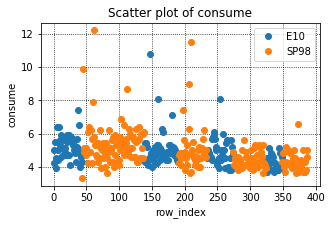


▼ consumeの分布 ※歪度： 2.9375519738571607


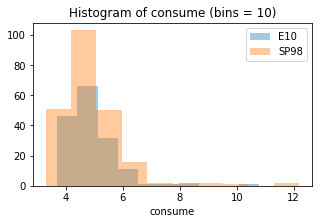


▼ 対数変換したconsumeの分布


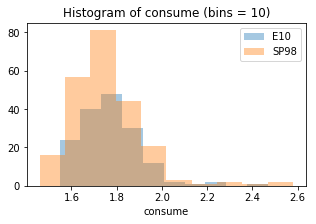

In [4]:
# ------------------------------------------------
# 2-2.目的変数（consume）の前処理
# ------------------------------------------------
show_scatter_plot('consume', 5,3)
show_histogram('consume',5,3,10)
show_histogram_log1p('consume',5,3,10)

### 2-3.説明変数の確認


▼ distanceの分布 ※歪度： 5.483255945470026


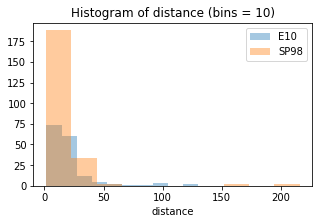


▼ 対数変換したdistanceの分布


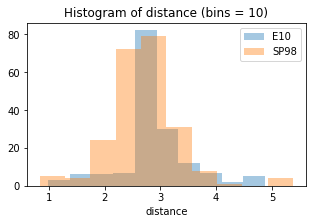


▼ consumeとdistanceの散布図


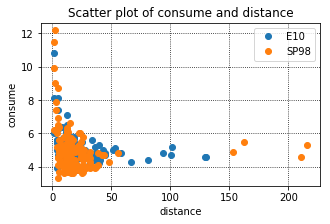

In [5]:
# ------------------------------------------------
# 2-3-1.distance
# ------------------------------------------------
show_histogram('distance',5,3,10)
show_histogram_log1p('distance',5,3,10)
show_scatter_plot_2item('consume','distance',5,3)


▼ speedの分布 ※歪度： 0.753315883801629


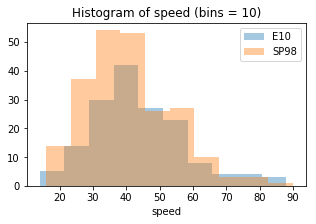


▼ consumeとspeedの散布図


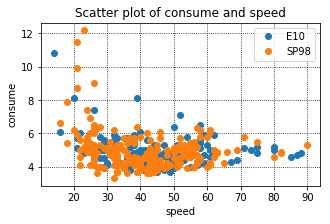

In [6]:
# ------------------------------------------------
# 2-3-2.speed
# ------------------------------------------------
show_histogram('speed',5,3,10)
show_scatter_plot_2item('consume','speed',5,3)

### 2-4.ダミー変換

In [7]:
# ダミー変換
df_dummies = pd.get_dummies(df, columns=['gas_type'])

print("\n▼ 先頭データ5件")
display(df_dummies.head())

## データを標準化(fit_transformとtransformを分ける為、test_splitの後に実施する)
#scaler = StandardScaler()        
#df['temp_diff'] = scaler.fit_transform(df.loc[:, ['temp_diff']])
#df['temp_inside'] = scaler.fit_transform(df.loc[:, ['temp_inside']])
#df['temp_outside'] = scaler.fit_transform(df.loc[:, ['temp_outside']])
#df['distance'] = scaler.fit_transform(df.loc[:, ['distance']])
#df['speed'] = scaler.fit_transform(df.loc[:, ['speed']])


▼ 先頭データ5件


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,gas_type_E10,gas_type_SP98
0,28.0,5.0,26,21.5,12,0,0,0,1,0
1,12.0,4.2,30,21.5,13,0,0,0,1,0
2,11.2,5.5,38,21.5,15,0,0,0,1,0
3,12.9,3.9,36,21.5,14,0,0,0,1,0
4,18.5,4.5,46,21.5,15,0,0,0,1,0


## 3.モデル構築

In [8]:
# ****************************************************************************
# ◆ 3.モデル構築
# ****************************************************************************
scaler = StandardScaler()  #スケーリング
param_grid = [0.001, 0.01, 0.1, 1.0, 10.0,100.0,1000.0] #パラメータグリッド
cnt = 0

# 係数を求める
X = df_dummies.drop('consume', axis=1).values
y = df_dummies["consume"].values

# パラメータでループ
for alpha in param_grid:

    #Lasso回帰モデル
    ls = Lasso(alpha=alpha)
    
    #パイプライン生成
    pipeline = make_pipeline(scaler, ls) # 学習モデルインスタンス
    
    # ホールドアウト法
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=0)
    
    # データを標準化
    X_train_norm = X_train
    X_test_norm = X_test

    # 先頭4列を標準化
    X_train_norm[:,:4] = scaler.fit_transform(X_train[:,:4])
    X_test_norm[:,:4] = scaler.transform(X_test[:,:4])
    
    # 学習
    pipeline.fit(X_train_norm,y_train)

    # 学習データのRMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train_norm)))
    
    # テストデータのRMSE
    test_rmse = np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test_norm)))
    
    if cnt == 0:
        best_score = test_rmse
        best_estimator = pipeline
        best_param = alpha
    elif best_score > test_rmse:
        # より小さいRMSEを見つけた場合
        best_score = test_rmse
        best_estimator = pipeline
        best_param = alpha
    else:
        pass
    cnt = cnt + 1
    
print('\n▼ ベストスコア')
print('alpha : ' + str(best_param))
print('test score is : {:.3f}'.format(best_score))


▼ ベストスコア
alpha : 0.001
test score is : 1.044



▼ モデルの検証


<Figure size 432x288 with 0 Axes>

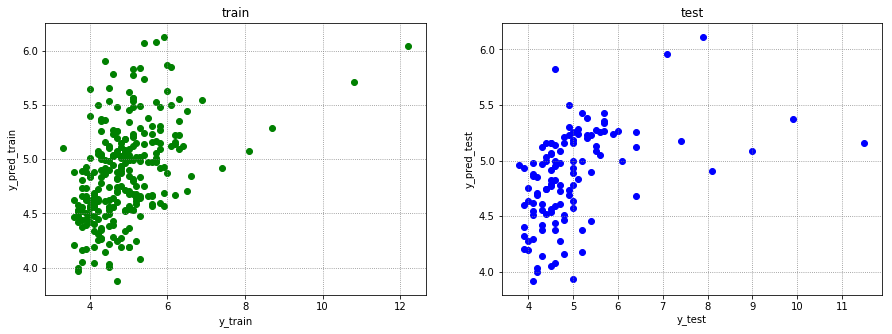

In [9]:
# ****************************************************************************
# ◆ 4.モデルの検証
# ****************************************************************************
print('\n▼ モデルの検証')
# 学習したモデルが実際に教師データにどれくらい近似できているのか
# 横軸が教師データ、縦軸が予測結果としてデータを散布
plt.subplots_adjust(wspace=0.8) # 余白
plt.figure(figsize=(15,5))

# 学習データ
plt.subplot(121) # plt.subplot(行数, 列数, 何番目のプロットか)
plt.scatter(y_train, best_estimator.predict(X_train), c='green')
plt.title('train')
plt.xlabel('y_train')
plt.ylabel('y_pred_train')
plt.grid(which='major',color='gray',linestyle=':')
plt.grid(which='minor',color='gray',linestyle=':')


# テストデータ
plt.subplot(122) # plt.subplot(行数, 列数, 何番目のプロットか)
plt.scatter(y_test, best_estimator.predict(X_test_norm), c='blue')
plt.title('test')
plt.xlabel('y_test')
plt.ylabel('y_pred_test')
plt.grid(which='major',color='gray',linestyle=':')
plt.grid(which='minor',color='gray',linestyle=':')

plt.show()

## 4.モデル評価

In [11]:
# ****************************************************************************
# ◆ 4.モデル評価
# ****************************************************************************

# 目的変数を予測
y_test_pred = best_estimator.predict(X_test_norm)

print('\n▼ モデルの評価結果')

# 二乗誤差(MSE)を計算
mse = mean_squared_error(y_test, y_test_pred) 
print("平均二乗和誤差(MSE) = %s"%round(mse,3) )  

# 絶対値誤差(MAE)を計算
mae = mean_absolute_error(y_test, y_test_pred) 
print("平均絶対値誤差(MAE) = %s"%round(mae,3) )

# 平方根二乗誤差(RMSE)を計算
rmse = np.sqrt(mse)
print("平方根平均二乗和誤差(RMSE) = %s"%round(rmse, 3) )


▼ モデルの評価結果
平均二乗和誤差(MSE) = 1.09
平均絶対値誤差(MAE) = 0.607
平方根平均二乗和誤差(RMSE) = 1.044
